✅ Biblioteki załadowane
📡 Łączenie z DigitalOcean Spaces...
✅ Dane wczytane:
   - 2023: 8950 wierszy
   - 2024: 13007 wierszy
🧹 Czyszczenie danych...

=== ROK 2023 ===
Przed filtrowaniem: 8950 wierszy
Po usunięciu DNF/DNS: 8150 wierszy
Usunięto 0 outlierów z kolumny 'Tempo'
Po oczyszczeniu: 7914 wierszy
Usunięto: 1036 wierszy (11.58%)

=== ROK 2024 ===
Przed filtrowaniem: 13007 wierszy
Po usunięciu DNF/DNS: 10300 wierszy
Usunięto 0 outlierów z kolumny 'Tempo'
Po oczyszczeniu: 9995 wierszy
Usunięto: 3012 wierszy (23.16%)

=== ŁĄCZENIE DANYCH ===

✅ Dane połączone: 17909 wierszy
📊 Podstawowe statystyki oczyszczonych danych:

Rozmiar datasetu: (17909, 42)

Rozkład płci:
Płeć
M    12743
K     5166
Name: count, dtype: int64

Statystyki wieku:
count    17909.000000
mean        39.181529
std         10.231956
min         17.000000
25%         32.000000
50%         39.000000
75%         46.000000
max         89.000000
Name: Wiek, dtype: float64

Statystyki tempo:
count    17909.000000
mean    

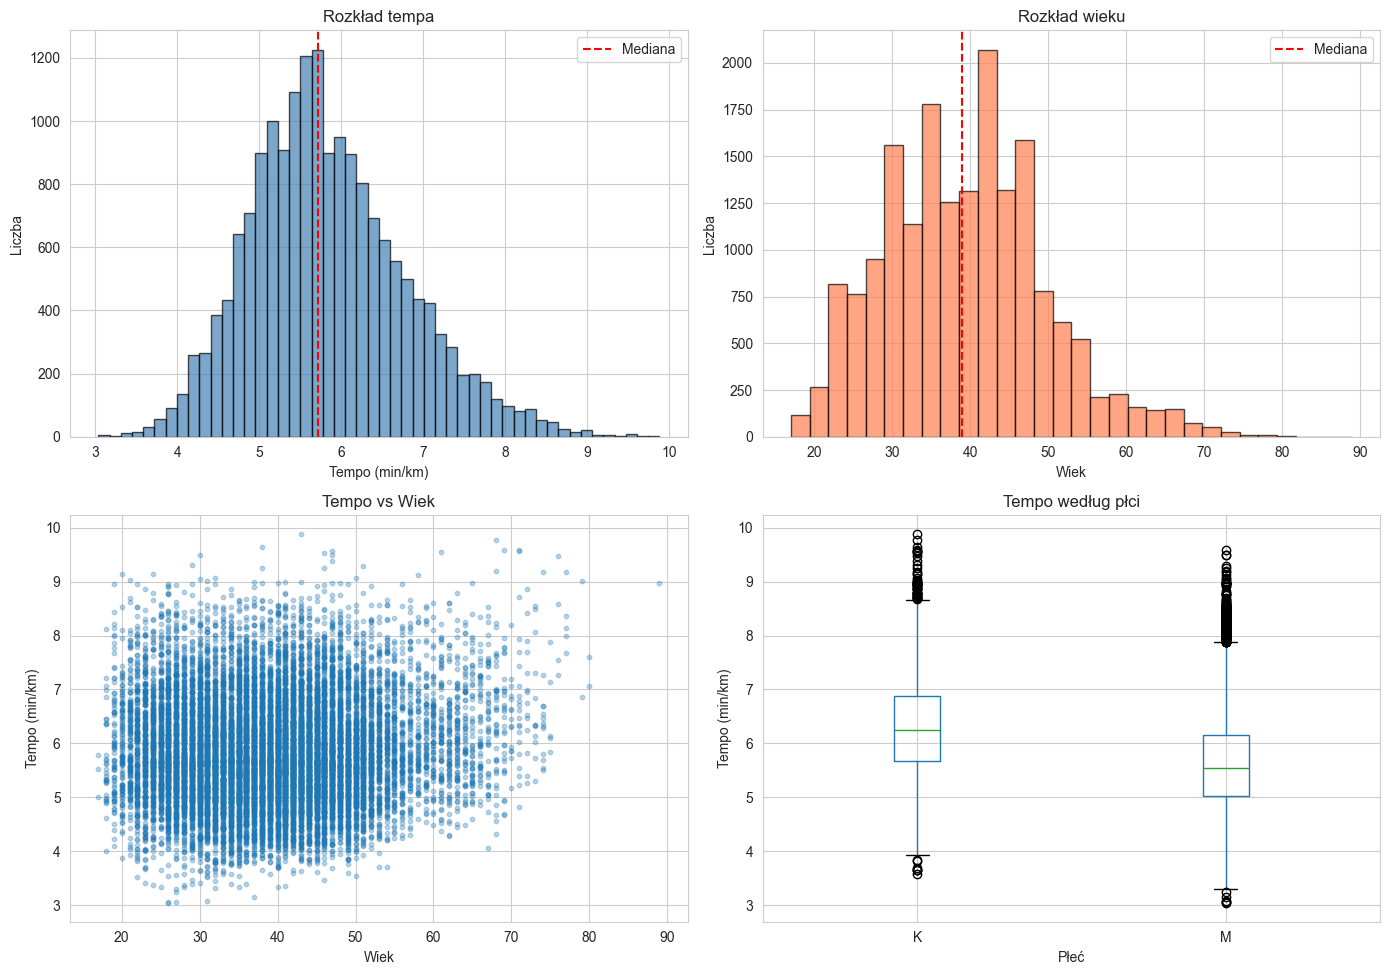

📊 Dane do modelowania: 17878 wierszy

Feature'y: ['Gender_Numeric', 'Wiek', '5 km Tempo', 'Tempo Stabilność', 'Has_Team', 'First_5km_Fast']
Target: Tempo

✅ X shape: (17878, 6)
✅ y shape: (17878,)
📊 Podział danych:
   - Train: 14302 wierszy (80.0%)
   - Test: 3576 wierszy (20.0%)

✅ Dane przygotowane do trenowania
🚀 Trenowanie modeli...

📈 Trenowanie: Linear Regression...
   ✅ MAE: 0.0650
   ✅ RMSE: 0.1005
   ✅ R²: 0.9891

📈 Trenowanie: Ridge Regression...
   ✅ MAE: 0.0650
   ✅ RMSE: 0.1005
   ✅ R²: 0.9891

📈 Trenowanie: Random Forest...
   ✅ MAE: 0.0694
   ✅ RMSE: 0.1051
   ✅ R²: 0.9881

📈 Trenowanie: Gradient Boosting...
   ✅ MAE: 0.0696
   ✅ RMSE: 0.1042
   ✅ R²: 0.9883

📊 Porównanie modeli:
            Model      MAE     RMSE       R²
Linear Regression 0.065041 0.100450 0.989132
 Ridge Regression 0.065046 0.100458 0.989130
    Random Forest 0.069432 0.105108 0.988101
Gradient Boosting 0.069554 0.104176 0.988311


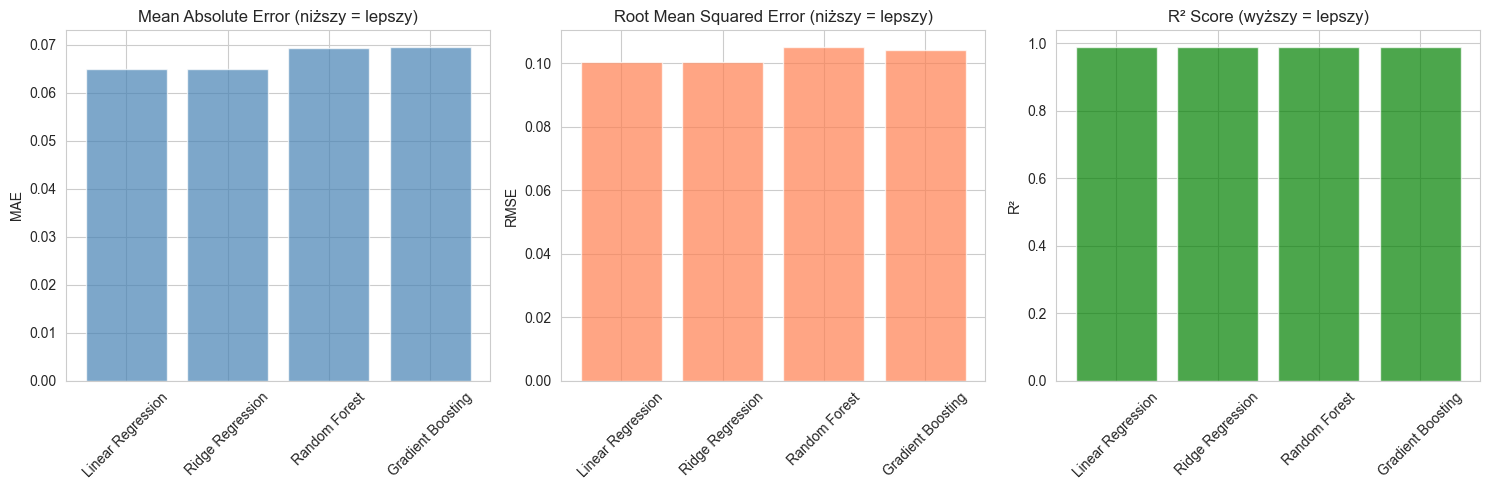


🏆 Najlepszy model: Linear Regression
   MAE: 0.0650 min/km
   RMSE: 0.1005 min/km
   R²: 0.9891

📊 Feature Importance (Random Forest):
         Feature  Importance
      5 km Tempo    0.877163
Tempo Stabilność    0.119255
            Wiek    0.002704
        Has_Team    0.000421
  Gender_Numeric    0.000344
  First_5km_Fast    0.000113


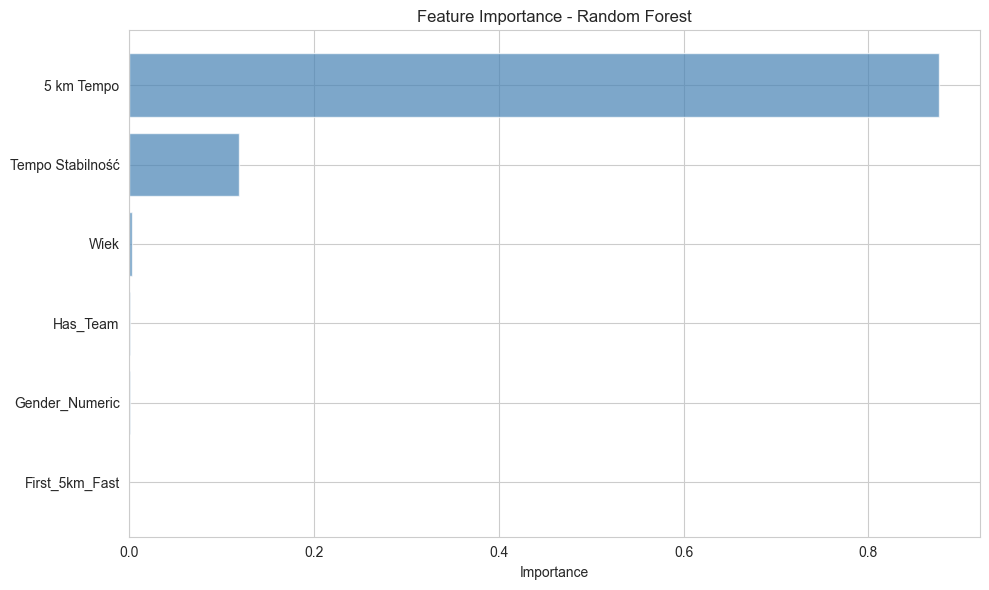

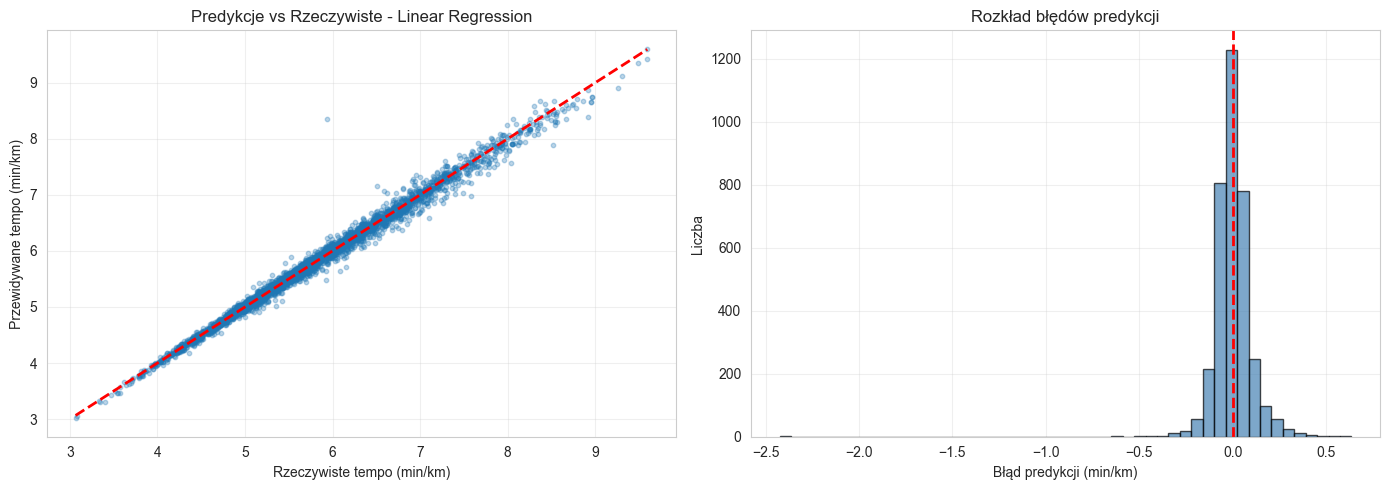


📊 Statystyki błędów:
   Średni błąd: 0.0010 min/km
   Mediana błędu: -0.0024 min/km
   Odchylenie std błędu: 0.1005 min/km
✅ Model zapisany lokalnie: models/halfmarathon_model_linear_regression.pkl
✅ Scaler zapisany lokalnie: models/scaler.pkl
✅ Informacje o modelu zapisane: models/model_info.json

☁️ Wysyłanie modelu na DigitalOcean Spaces...
   ✅ Wysłano: models/halfmarathon_model_linear_regression.pkl
   ✅ Wysłano: models/scaler.pkl
   ✅ Wysłano: models/model_info.json

✅ Model wysłany na DigitalOcean Spaces!

🎉 PIPELINE ZAKOŃCZONY POMYŚLNIE!

📊 Podsumowanie:
   - Wytrenowano 4 modeli
   - Najlepszy model: Linear Regression
   - MAE: 0.0650 min/km
   - RMSE: 0.1005 min/km
   - R²: 0.9891

💾 Model zapisany:
   - Lokalnie: models/halfmarathon_model_linear_regression.pkl
   - DigitalOcean: models/halfmarathon_model_*.pkl

🚀 Gotowe do wdrożenia w aplikacji Streamlit!


In [1]:
# %% [markdown]
# # 🏃‍♂️ Halfmarathon Wrocław - Model Training Pipeline
# 
# Ten notebook zawiera kompletny pipeline do:
# 1. Wczytywania danych z DigitalOcean Spaces
# 2. Czyszczenia i przygotowania danych
# 3. Feature engineering
# 4. Trenowania modelu predykcyjnego
# 5. Ewaluacji modelu
# 6. Zapisywania modelu lokalnie i na DigitalOcean

# %% [markdown]
## 1. Import bibliotek i konfiguracja

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import boto3
from dotenv import load_dotenv
import os
import sys

# Dodanie ścieżki do modułów utils
sys.path.append('..')
from utils.data_preprocessing import clean_data_for_modeling, prepare_features_for_model, merge_years_data

# Konfiguracja wyświetlania
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

# Załadowanie zmiennych środowiskowych
load_dotenv()

print("✅ Biblioteki załadowane")

# %% [markdown]
## 2. Wczytywanie danych z DigitalOcean Spaces

# %%
BUCKET_NAME = "dane-modul9"

# Inicjalizacja klienta S3 (DigitalOcean Spaces)
s3_client = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3")
)

print("📡 Łączenie z DigitalOcean Spaces...")

# Wczytanie danych
wroclaw_2023_df = pd.read_csv(
    f"s3://{BUCKET_NAME}/dane-zadanie_modul9/halfmarathon_wroclaw_2023__final.csv", 
    sep=";"
)
wroclaw_2024_df = pd.read_csv(
    f"s3://{BUCKET_NAME}/dane-zadanie_modul9/halfmarathon_wroclaw_2024__final.csv", 
    sep=";"
)

print(f"✅ Dane wczytane:")
print(f"   - 2023: {len(wroclaw_2023_df)} wierszy")
print(f"   - 2024: {len(wroclaw_2024_df)} wierszy")

# %% [markdown]
## 3. Czyszczenie i przygotowanie danych

# %%
print("🧹 Czyszczenie danych...")
print("\n=== ROK 2023 ===")
df_2023_clean = clean_data_for_modeling(wroclaw_2023_df, 2023)

print("\n=== ROK 2024 ===")
df_2024_clean = clean_data_for_modeling(wroclaw_2024_df, 2024)

# Połączenie danych z obu lat
print("\n=== ŁĄCZENIE DANYCH ===")
df_combined = pd.concat([df_2023_clean, df_2024_clean], ignore_index=True)
df_combined['Year'] = df_combined['Rocznik'].apply(lambda x: 2023 if x < 2010 else 2024)

print(f"\n✅ Dane połączone: {len(df_combined)} wierszy")

# %% [markdown]
## 4. Eksploracja oczyszczonych danych

# %%
print("📊 Podstawowe statystyki oczyszczonych danych:")
print(f"\nRozmiar datasetu: {df_combined.shape}")
print(f"\nRozkład płci:")
print(df_combined['Płeć'].value_counts())
print(f"\nStatystyki wieku:")
print(df_combined['Wiek'].describe())
print(f"\nStatystyki tempo:")
print(df_combined['Tempo'].describe())

# Wizualizacja rozkładów
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rozkład tempa
axes[0, 0].hist(df_combined['Tempo'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Tempo (min/km)')
axes[0, 0].set_ylabel('Liczba')
axes[0, 0].set_title('Rozkład tempa')
axes[0, 0].axvline(df_combined['Tempo'].median(), color='red', linestyle='--', label='Mediana')
axes[0, 0].legend()

# Rozkład wieku
axes[0, 1].hist(df_combined['Wiek'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Wiek')
axes[0, 1].set_ylabel('Liczba')
axes[0, 1].set_title('Rozkład wieku')
axes[0, 1].axvline(df_combined['Wiek'].median(), color='red', linestyle='--', label='Mediana')
axes[0, 1].legend()

# Tempo vs Wiek
axes[1, 0].scatter(df_combined['Wiek'], df_combined['Tempo'], alpha=0.3, s=10)
axes[1, 0].set_xlabel('Wiek')
axes[1, 0].set_ylabel('Tempo (min/km)')
axes[1, 0].set_title('Tempo vs Wiek')

# Tempo według płci
df_combined.boxplot(column='Tempo', by='Płeć', ax=axes[1, 1])
axes[1, 1].set_xlabel('Płeć')
axes[1, 1].set_ylabel('Tempo (min/km)')
axes[1, 1].set_title('Tempo według płci')
axes[1, 1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

# %% [markdown]
## 5. Przygotowanie feature'ów i target'a

# %%
# Wybór feature'ów do modelu
feature_columns = [
    'Gender_Numeric',        # Płeć (0=K, 1=M)
    'Wiek',                  # Wiek
    '5 km Tempo',            # Tempo na pierwszych 5km
    'Tempo Stabilność',      # Stabilność tempa
    'Has_Team',              # Czy należy do drużyny
    'First_5km_Fast',        # Czy pierwsze 5km było szybkie
]

# Target - tempo na mecie
target_column = 'Tempo'

# Usunięcie wierszy z brakującymi wartościami
df_model = df_combined[feature_columns + [target_column]].dropna()

print(f"📊 Dane do modelowania: {len(df_model)} wierszy")
print(f"\nFeature'y: {feature_columns}")
print(f"Target: {target_column}")

# Przygotowanie X i y
X = df_model[feature_columns]
y = df_model[target_column]

print(f"\n✅ X shape: {X.shape}")
print(f"✅ y shape: {y.shape}")

# %% [markdown]
## 6. Podział danych na train/test

# %%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"📊 Podział danych:")
print(f"   - Train: {len(X_train)} wierszy ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test: {len(X_test)} wierszy ({len(X_test)/len(X)*100:.1f}%)")

# Standaryzacja (opcjonalna, ale może poprawić wyniki niektórych modeli)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Dane przygotowane do trenowania")

# %% [markdown]
## 7. Trenowanie modeli

# %%
print("🚀 Trenowanie modeli...")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n📈 Trenowanie: {name}...")
    
    # Trenowanie
    if name in ['Linear Regression', 'Ridge Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Ewaluacja
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': model,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"   ✅ MAE: {mae:.4f}")
    print(f"   ✅ RMSE: {rmse:.4f}")
    print(f"   ✅ R²: {r2:.4f}")

# %% [markdown]
## 8. Porównanie modeli

# %%
# Dataframe z wynikami
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['mae'] for m in results.keys()],
    'RMSE': [results[m]['rmse'] for m in results.keys()],
    'R²': [results[m]['r2'] for m in results.keys()]
}).sort_values('MAE')

print("\n📊 Porównanie modeli:")
print(results_df.to_string(index=False))

# Wizualizacja
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MAE
axes[0].bar(results_df['Model'], results_df['MAE'], color='steelblue', alpha=0.7)
axes[0].set_ylabel('MAE')
axes[0].set_title('Mean Absolute Error (niższy = lepszy)')
axes[0].tick_params(axis='x', rotation=45)

# RMSE
axes[1].bar(results_df['Model'], results_df['RMSE'], color='coral', alpha=0.7)
axes[1].set_ylabel('RMSE')
axes[1].set_title('Root Mean Squared Error (niższy = lepszy)')
axes[1].tick_params(axis='x', rotation=45)

# R²
axes[2].bar(results_df['Model'], results_df['R²'], color='green', alpha=0.7)
axes[2].set_ylabel('R²')
axes[2].set_title('R² Score (wyższy = lepszy)')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Najlepszy model
best_model_name = results_df.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n🏆 Najlepszy model: {best_model_name}")
print(f"   MAE: {results[best_model_name]['mae']:.4f} min/km")
print(f"   RMSE: {results[best_model_name]['rmse']:.4f} min/km")
print(f"   R²: {results[best_model_name]['r2']:.4f}")

# %% [markdown]
## 9. Feature Importance (dla Random Forest)

# %%
if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']
    
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\n📊 Feature Importance (Random Forest):")
    print(feature_importance.to_string(index=False))
    
    # Wizualizacja
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue', alpha=0.7)
    plt.xlabel('Importance')
    plt.title('Feature Importance - Random Forest')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# %% [markdown]
## 10. Analiza predykcji

# %%
# Predykcje vs wartości rzeczywiste dla najlepszego modelu
best_predictions = results[best_model_name]['predictions']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(y_test, best_predictions, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Rzeczywiste tempo (min/km)')
axes[0].set_ylabel('Przewidywane tempo (min/km)')
axes[0].set_title(f'Predykcje vs Rzeczywiste - {best_model_name}')
axes[0].grid(True, alpha=0.3)

# Histogram błędów
errors = y_test - best_predictions
axes[1].hist(errors, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', lw=2)
axes[1].set_xlabel('Błąd predykcji (min/km)')
axes[1].set_ylabel('Liczba')
axes[1].set_title('Rozkład błędów predykcji')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Statystyki błędów:")
print(f"   Średni błąd: {errors.mean():.4f} min/km")
print(f"   Mediana błędu: {errors.median():.4f} min/km")
print(f"   Odchylenie std błędu: {errors.std():.4f} min/km")

# %% [markdown]
## 11. Zapisywanie modelu lokalnie

# %%
# Utworzenie katalogu models jeśli nie istnieje
os.makedirs('models', exist_ok=True)

# Zapisanie najlepszego modelu
model_filename = f'models/halfmarathon_model_{best_model_name.replace(" ", "_").lower()}.pkl'
scaler_filename = 'models/scaler.pkl'

joblib.dump(best_model, model_filename)
joblib.dump(scaler, scaler_filename)

print(f"✅ Model zapisany lokalnie: {model_filename}")
print(f"✅ Scaler zapisany lokalnie: {scaler_filename}")

# Zapisanie informacji o modelu
model_info = {
    'model_name': best_model_name,
    'features': feature_columns,
    'mae': results[best_model_name]['mae'],
    'rmse': results[best_model_name]['rmse'],
    'r2': results[best_model_name]['r2'],
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'training_samples': len(X_train)
}

import json
with open('models/model_info.json', 'w') as f:
    json.dump(model_info, f, indent=4)

print(f"✅ Informacje o modelu zapisane: models/model_info.json")

# %% [markdown]
## 12. Upload modelu na DigitalOcean Spaces

# %%
print("\n☁️ Wysyłanie modelu na DigitalOcean Spaces...")

def upload_file_to_spaces(local_file, remote_file):
    """Upload pliku do DigitalOcean Spaces"""
    try:
        s3_client.upload_file(local_file, BUCKET_NAME, remote_file)
        print(f"   ✅ Wysłano: {remote_file}")
        return True
    except Exception as e:
        print(f"   ❌ Błąd: {e}")
        return False

# Upload modelu
upload_file_to_spaces(
    model_filename, 
    f'models/halfmarathon_model_{best_model_name.replace(" ", "_").lower()}.pkl'
)

# Upload scalera
upload_file_to_spaces(
    scaler_filename,
    'models/scaler.pkl'
)

# Upload informacji o modelu
upload_file_to_spaces(
    'models/model_info.json',
    'models/model_info.json'
)

print("\n✅ Model wysłany na DigitalOcean Spaces!")

# %% [markdown]
## 13. Podsumowanie

# %%
print("\n" + "="*60)
print("🎉 PIPELINE ZAKOŃCZONY POMYŚLNIE!")
print("="*60)
print(f"\n📊 Podsumowanie:")
print(f"   - Wytrenowano {len(models)} modeli")
print(f"   - Najlepszy model: {best_model_name}")
print(f"   - MAE: {results[best_model_name]['mae']:.4f} min/km")
print(f"   - RMSE: {results[best_model_name]['rmse']:.4f} min/km")
print(f"   - R²: {results[best_model_name]['r2']:.4f}")
print(f"\n💾 Model zapisany:")
print(f"   - Lokalnie: {model_filename}")
print(f"   - DigitalOcean: models/halfmarathon_model_*.pkl")
print(f"\n🚀 Gotowe do wdrożenia w aplikacji Streamlit!")
print("="*60)

# %%